# **Linear Regression using PySpark MLlib**

**Objective:** predict housing prices in California based on location, number of rooms, ocean proximity, etc.

## 0 Workspace Set-Up

In [33]:
pip install phik -q

In [34]:
# Imports

# General
import pandas as pd

# Data viz
import seaborn as sns
import matplotlib.pyplot as plt
from phik import phik_matrix

# Spark
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

# Spark ML
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


In [35]:
RANDOM_SEED = 42

## 1. Reading the Dataset

In [36]:
# Inititate a Spark session

spark = SparkSession.builder \
                    .master('local') \
                    .appName('CA Housing Prices') \
                    .getOrCreate()

In [37]:
# Read csv
df = spark.read.load(
    '/content/CA_housing_prices_wo_features.csv',
    format='csv',
    inferSchema=True,
    header='true'
)

In [38]:
# Check data types
df.printSchema()

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



In [39]:
# Overview
df.show(5)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|              

The dataset contains:
- eight continuous numeric features,
- one categoric feature,
- a continuous numeric target variable: 'median_house_value'.

The datatypes are correct.

## 2. EDA

In [40]:
# Number of rows
df.count()

20640

In [41]:
# Statistical data
df.describe().show()

+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+
|summary|          longitude|         latitude|housing_median_age|       total_rooms|    total_bedrooms|        population|       households|     median_income|median_house_value|ocean_proximity|
+-------+-------------------+-----------------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+---------------+
|  count|              20640|            20640|             20640|             20640|             20433|             20640|            20640|             20640|             20640|          20640|
|   mean|-119.56970445736148| 35.6318614341087|28.639486434108527|2635.7630813953488| 537.8705525375618|1425.4767441860465|499.5396802325581|3.8706710029070246|206855.81690891474|           NULL|
| stddev|  2.0035317

- Many features show quite a large dispersion.
- It appears that features 'total_bedrooms' has missing values.

In [42]:
df.columns

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value',
 'ocean_proximity']

In [43]:
# Check the nr of missing values

for column in df.columns:
    null_count = df.filter(F.col(column).isNull()).count()
    print(f"Column '{column}' has {null_count} missing values.")

Column 'longitude' has 0 missing values.
Column 'latitude' has 0 missing values.
Column 'housing_median_age' has 0 missing values.
Column 'total_rooms' has 0 missing values.
Column 'total_bedrooms' has 207 missing values.
Column 'population' has 0 missing values.
Column 'households' has 0 missing values.
Column 'median_income' has 0 missing values.
Column 'median_house_value' has 0 missing values.
Column 'ocean_proximity' has 0 missing values.


In [44]:
numeric_cols = [col for col, dtype in df.dtypes if dtype == 'double']

In [45]:
numeric_cols

['longitude',
 'latitude',
 'housing_median_age',
 'total_rooms',
 'total_bedrooms',
 'population',
 'households',
 'median_income',
 'median_house_value']

In [46]:
# Create a sample for EDA in pandas

fraction = 0.1
seed = 42

sampled_df = df.sample(withReplacement=False, fraction=fraction, seed=seed)

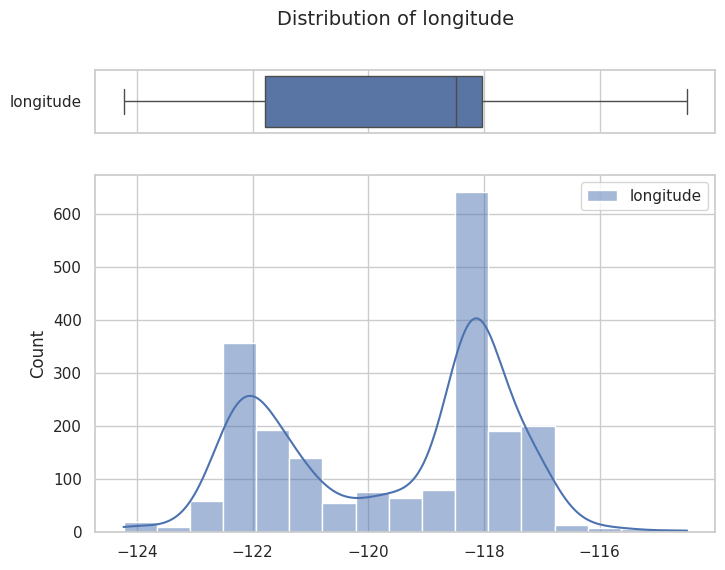

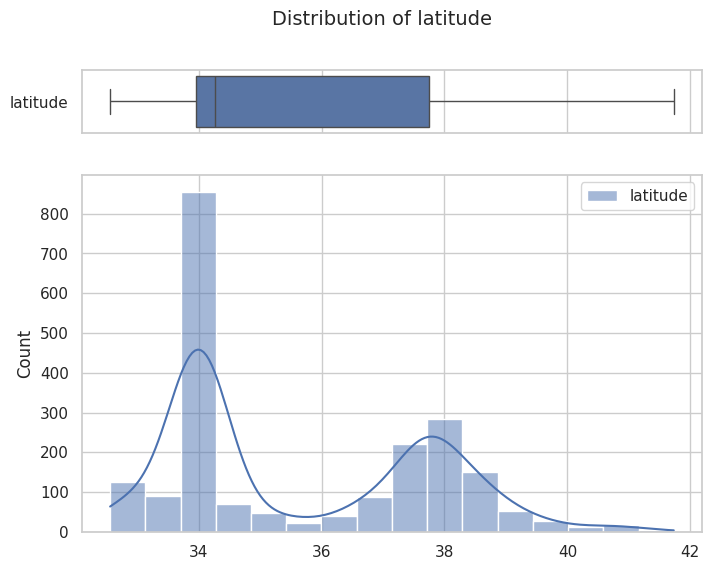

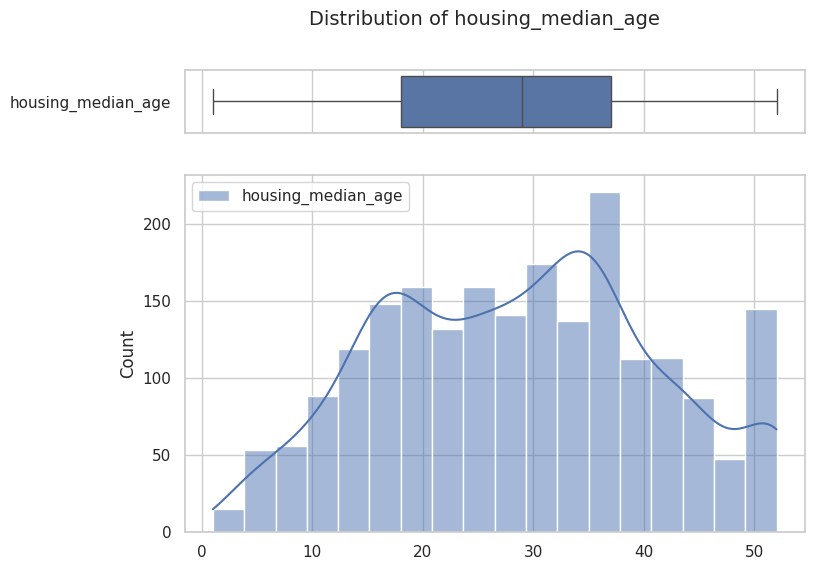

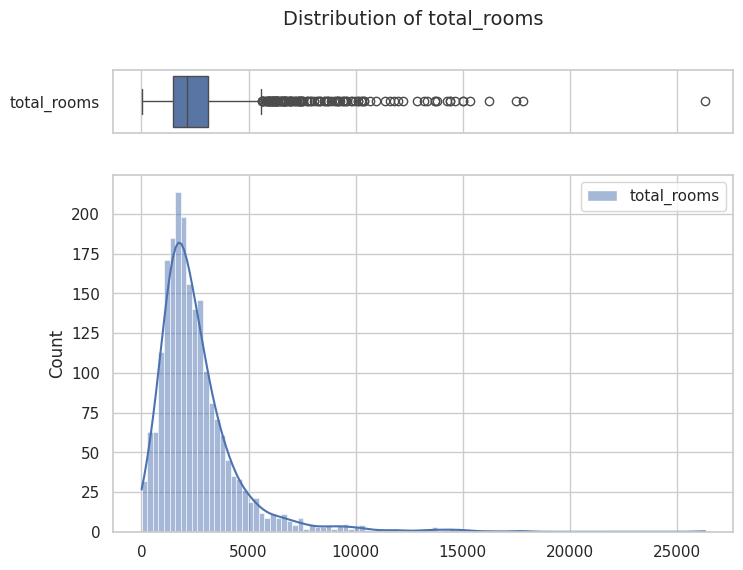

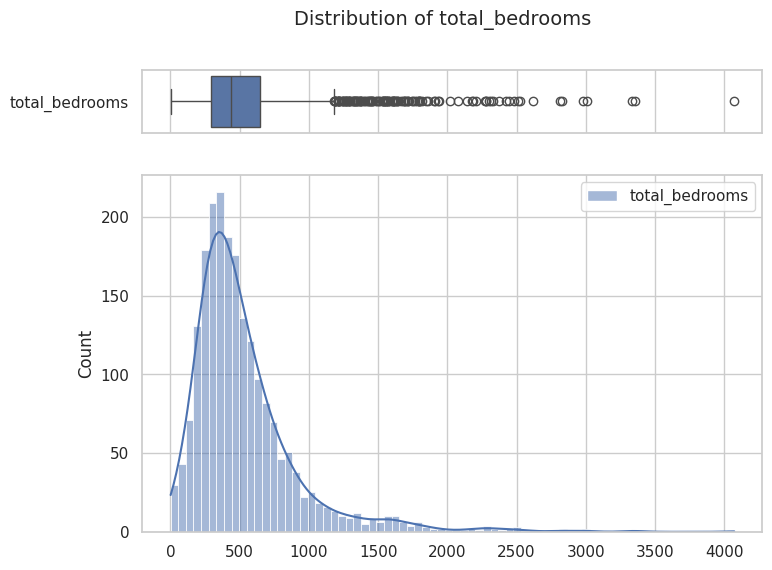

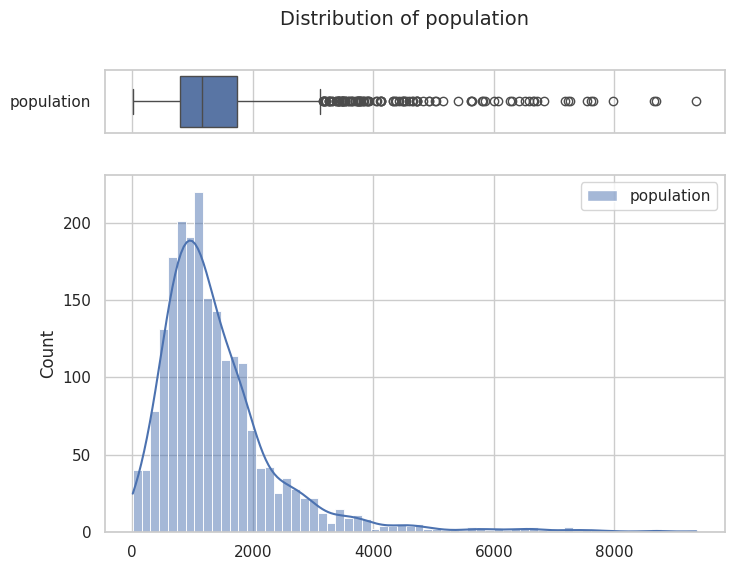

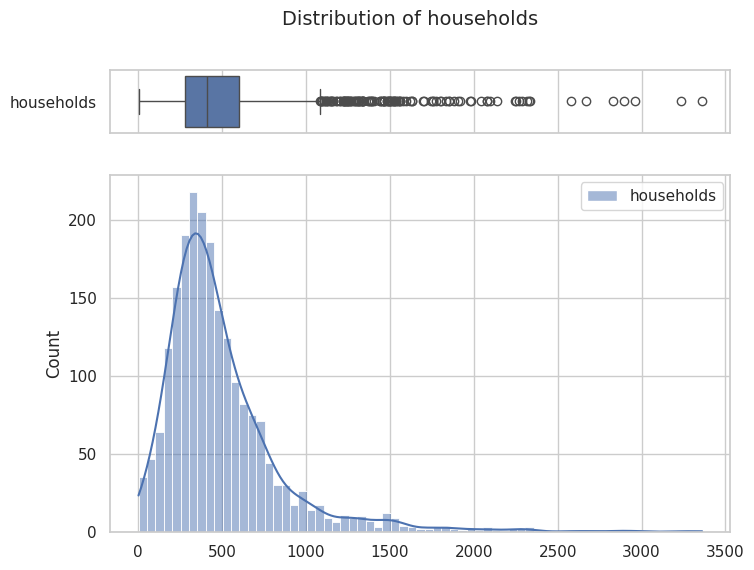

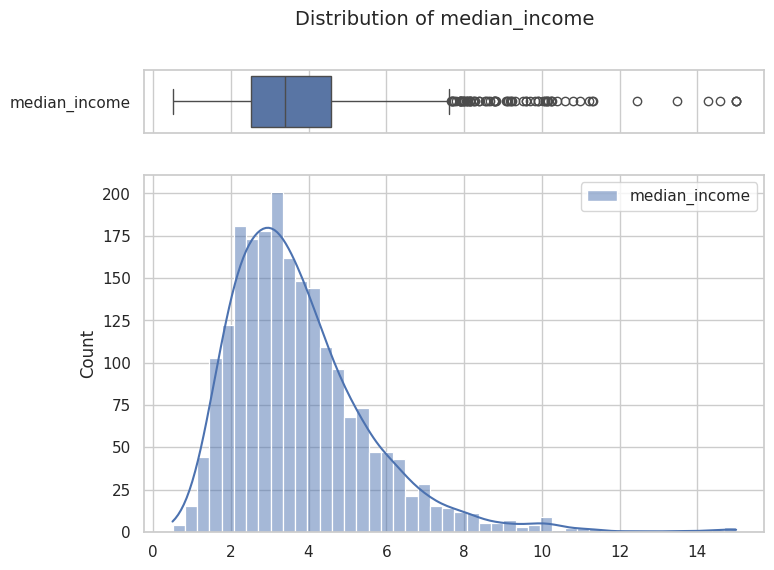

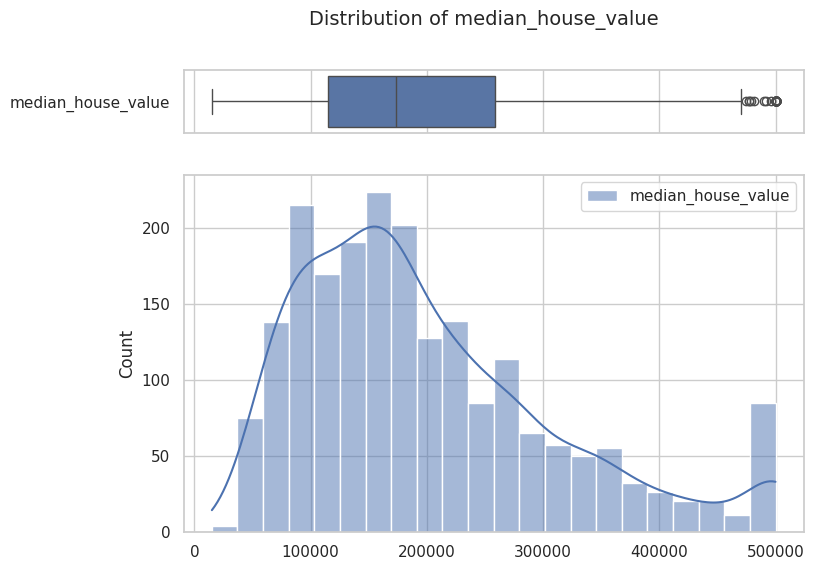

In [47]:
# Check distribution of the numeric values

for col in numeric_cols:

    _df = sampled_df.select(col).toPandas()

    f, (ax_box, ax_hist) = plt.subplots(
        2,
        sharex=True,
        gridspec_kw={"height_ratios": (.15, .85)},
        figsize=(8, 6)
    )

    sns.set(style="whitegrid")

    sns.boxplot(_df, orient="h", ax=ax_box)

    sns.histplot(_df, ax=ax_hist, kde=True)

    ax_box.set(xlabel='')

    plt.suptitle(f'Distribution of {col}', fontsize=14)

    plt.show()

- The graphs above indicate a great number of outliers.
- However, it cannot be conclusively stated that thoese are atypical for this particular domain.
- All data will be retained for the modelling process.

## 3. Handling the Missing Data

In [48]:
# Select features to check correlation with 'total_bedrooms'

_df = sampled_df.select(numeric_cols).toPandas()

In [49]:
_df.dropna(inplace=True)

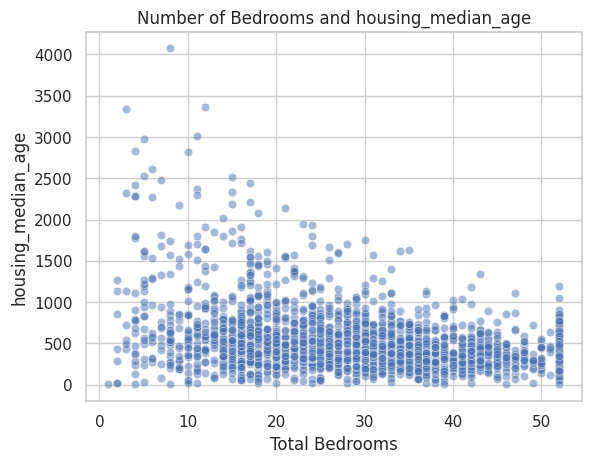

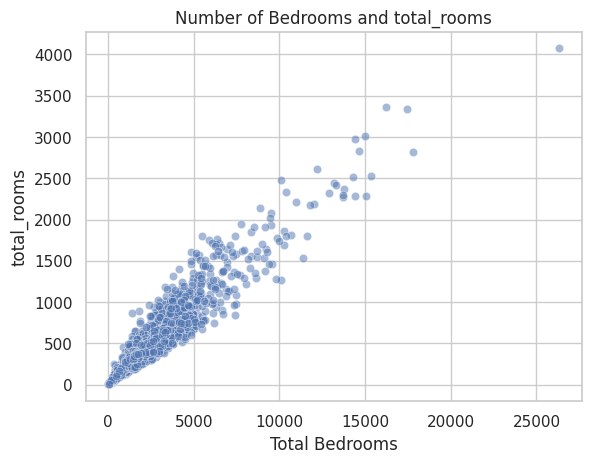

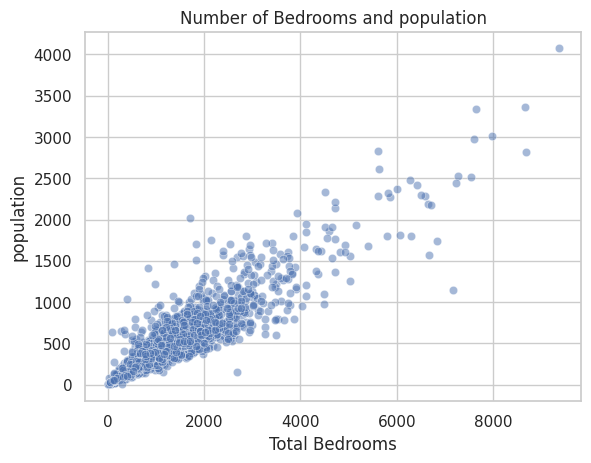

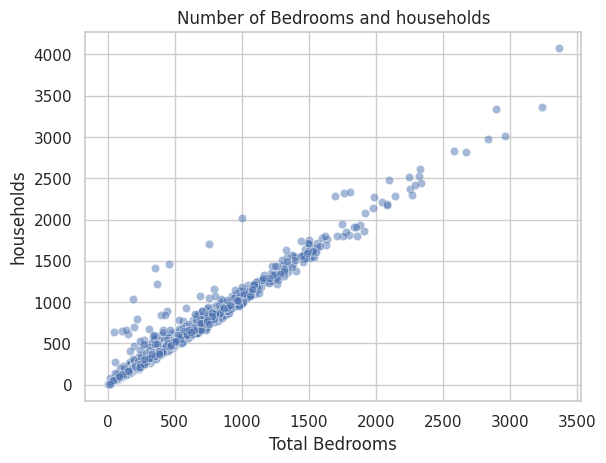

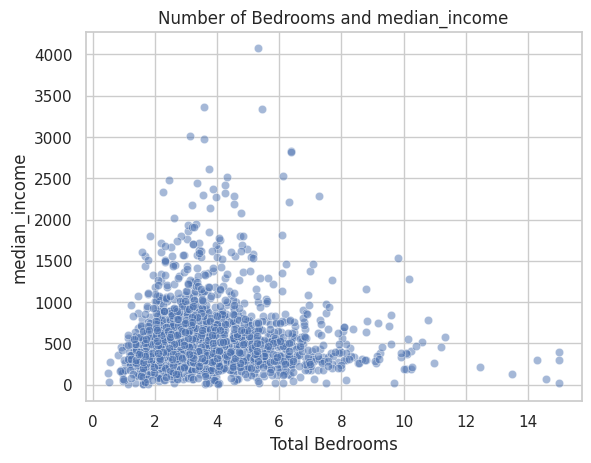

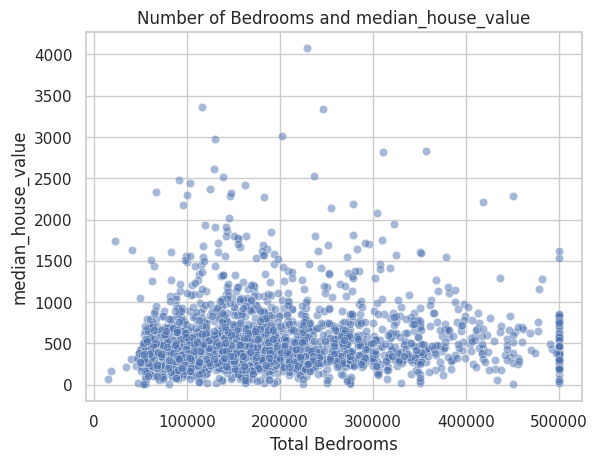

In [50]:
cols = [
    'housing_median_age',
    'total_rooms',
    #'total_bedrooms',
    'population',
    'households',
    'median_income',
    'median_house_value'
]

# Graphic representation of relationship between 'total_bedrooms' and other features

for col in cols:
    sns.scatterplot(x=_df[col], y=_df['total_bedrooms'], alpha=0.5)

    plt.title(f"Number of Bedrooms and {col}")
    plt.xlabel("Total Bedrooms")
    plt.ylabel(col)
    plt.show()

- Three features demonstrate strong linear relationships with 'total_bedrooms'.

In [51]:
# check linear correlation
_cols = [
    'population',
    'households',
    'total_rooms'
]

for col in _cols:
  correlation = _df['total_bedrooms'].corr(_df[col])
  print(f'Correlation between number of bedrooms and {col} is {round(correlation, 2)}')


Correlation between number of bedrooms and population is 0.9
Correlation between number of bedrooms and households is 0.98
Correlation between number of bedrooms and total_rooms is 0.94


- The missing values in the 'total_bedrooms' will be filled out with the median value by number of households.

In [52]:
mean_df = df.groupBy('households').agg(F.median('total_bedrooms').alias('total_bedrooms_mean'))
mean_df.show(5)

+----------+-------------------+
|households|total_bedrooms_mean|
+----------+-------------------+
|       1.0|                1.0|
|       2.0|                2.0|
|       3.0|                3.5|
|       4.0|                5.5|
|       5.0|                5.0|
+----------+-------------------+
only showing top 5 rows



In [53]:
df = df.join(mean_df, on='households', how='left')
df.show(5)

+----------+---------+--------+------------------+-----------+--------------+----------+-------------+------------------+---------------+-------------------+
|households|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|median_income|median_house_value|ocean_proximity|total_bedrooms_mean|
+----------+---------+--------+------------------+-----------+--------------+----------+-------------+------------------+---------------+-------------------+
|     126.0|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|       8.3252|          452600.0|       NEAR BAY|              138.5|
|    1138.0|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|       8.3014|          358500.0|       NEAR BAY|             1201.0|
|     177.0|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|       7.2574|          352100.0|       NEAR BAY|              184.0|
|     219.0|  -122.25|   37.85|              52.0|  

In [54]:
# Fill out the missing values

df = df.withColumn(
    'total_bedrooms',
    F.when(F.col('total_bedrooms').isNull(), F.col('total_bedrooms_mean')).otherwise(F.col('total_bedrooms'))
).drop('total_bedrooms_mean')

df.show(5)

+----------+---------+--------+------------------+-----------+--------------+----------+-------------+------------------+---------------+
|households|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|median_income|median_house_value|ocean_proximity|
+----------+---------+--------+------------------+-----------+--------------+----------+-------------+------------------+---------------+
|     126.0|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|       8.3252|          452600.0|       NEAR BAY|
|    1138.0|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|       8.3014|          358500.0|       NEAR BAY|
|     177.0|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|       7.2574|          352100.0|       NEAR BAY|
|     219.0|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|       5.6431|          341300.0|       NEAR BAY|
|     259.0|  -122.25|   37.85|   

In [55]:
df.filter(F.col('total_bedrooms').isNull()).count()

6

- It appears there are 6 missing values left in 'total_bedrooms'.
- These will be dropped.

In [56]:
# drop the rows with missing 'total_bedrooms'

df = df.dropna(subset=['total_bedrooms'])

In [57]:
df.filter(F.col('total_bedrooms').isNull()).count()

0

## 4. Phi-correlation

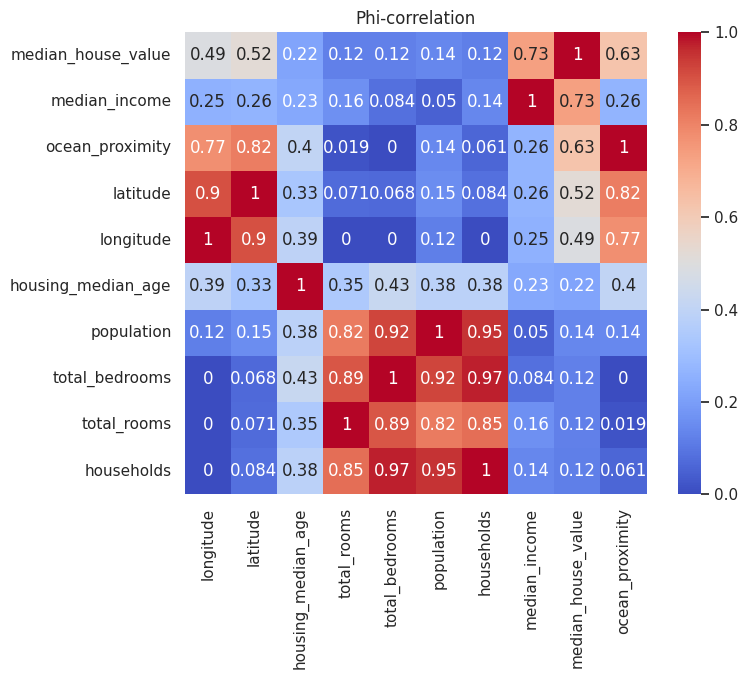

In [58]:
# Check for multicollinearity using Phi correlation

_df = sampled_df.toPandas()

num_cols = [col for col in _df.columns if _df[col].dtype in ['float64', 'int64']]

matrix = _df.phik_matrix(interval_cols=num_cols).sort_values(by='median_house_value', ascending=False)

plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, cmap='coolwarm', square=True)
plt.title("Phi-correlation")
plt.show()

- There is a very high correlation between 'total_bedrooms', 'total_rooms' and 'households,' so two of them should be excluded from the features used during the modeling process.

## 5. Feature Engineering

In [59]:
# Generate new features

df = df \
    .withColumn('rooms_per_household', F.col('total_rooms') / F.col('households')) \
    .withColumn('population_in_household', F.col('population') / F.col('households')) \
    .withColumn('bedroom_index', F.col('total_bedrooms') / F.col('total_rooms'))

df.printSchema()

root
 |-- households: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)
 |-- rooms_per_household: double (nullable = true)
 |-- population_in_household: double (nullable = true)
 |-- bedroom_index: double (nullable = true)



In [60]:
# Create a sample for EDA in pandas

fraction = 0.1
seed = 42

sampled_df = df.sample(withReplacement=False, fraction=fraction, seed=seed)

In [61]:
# Check linear relationship

_df = sampled_df.toPandas()


In [62]:
_df.columns

Index(['households', 'longitude', 'latitude', 'housing_median_age',
       'total_rooms', 'total_bedrooms', 'population', 'median_income',
       'median_house_value', 'ocean_proximity', 'rooms_per_household',
       'population_in_household', 'bedroom_index'],
      dtype='object')

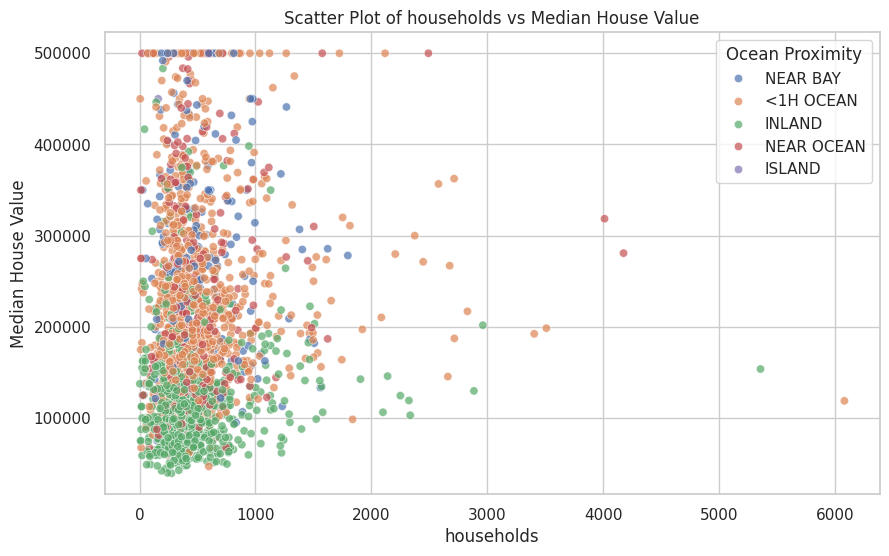

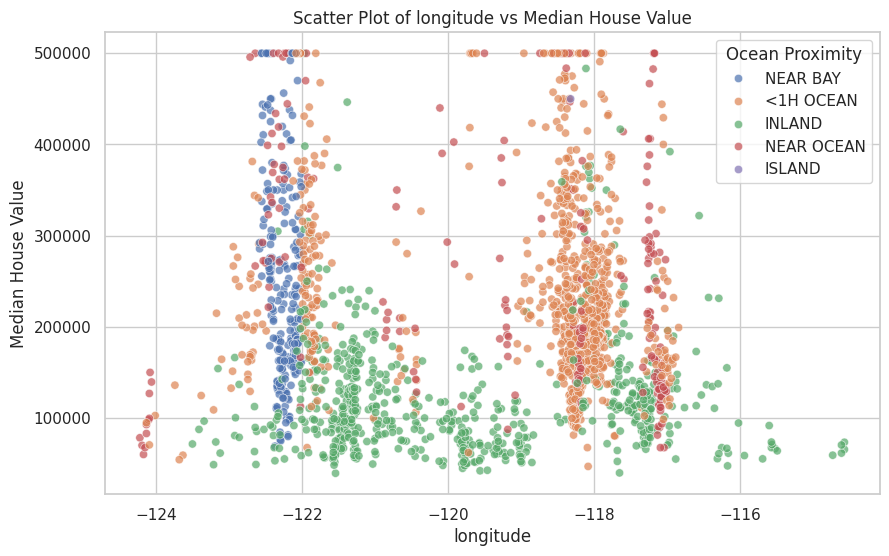

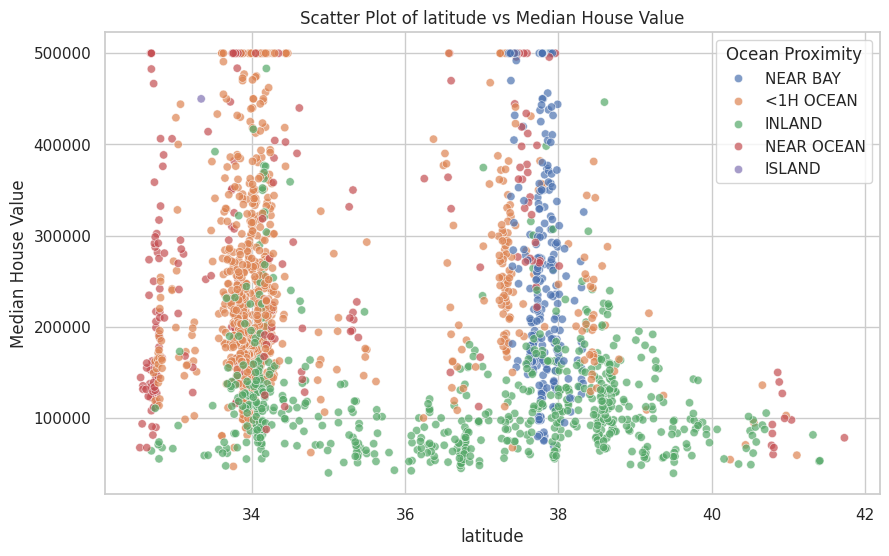

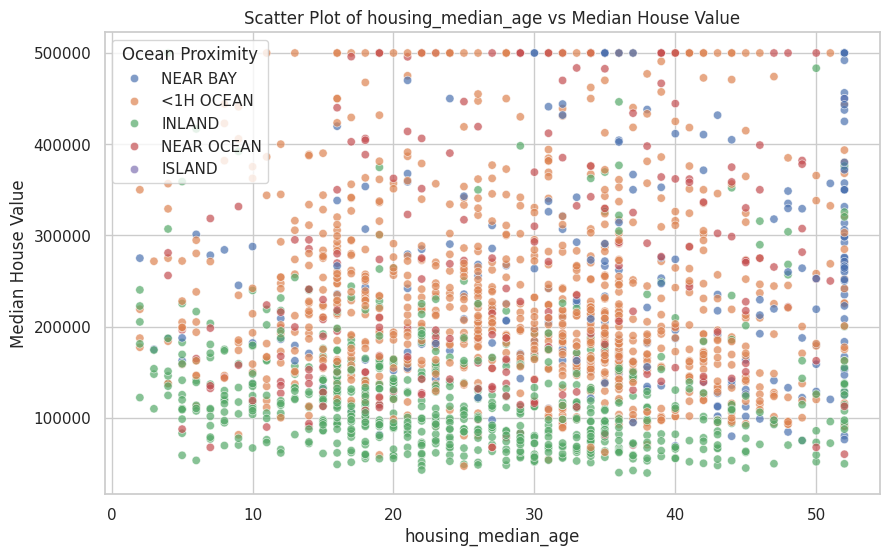

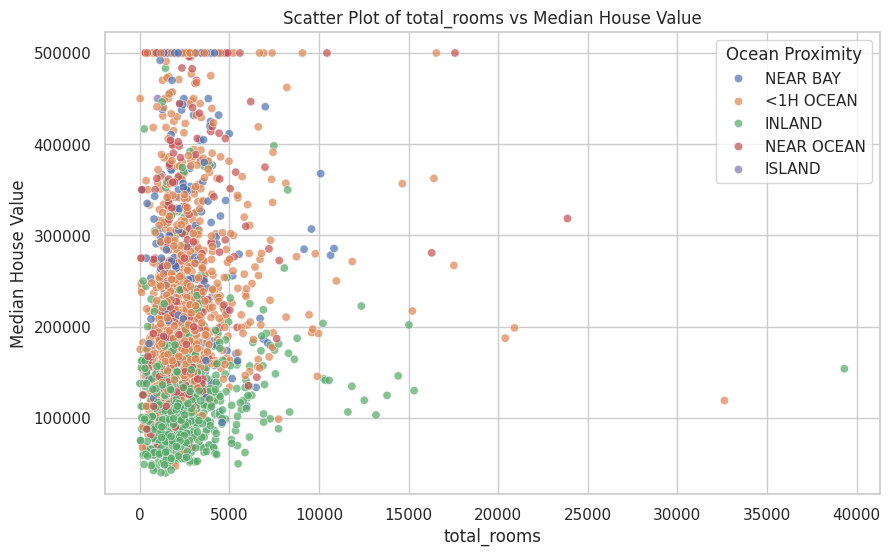

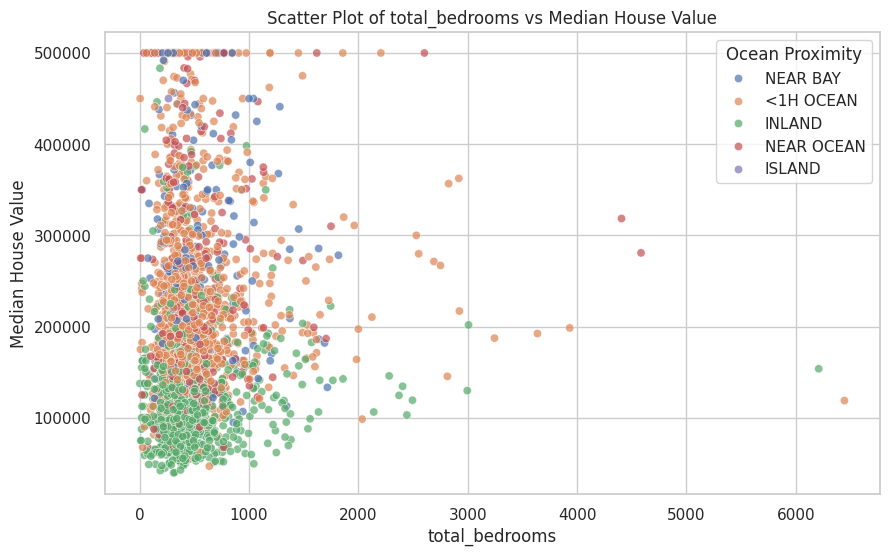

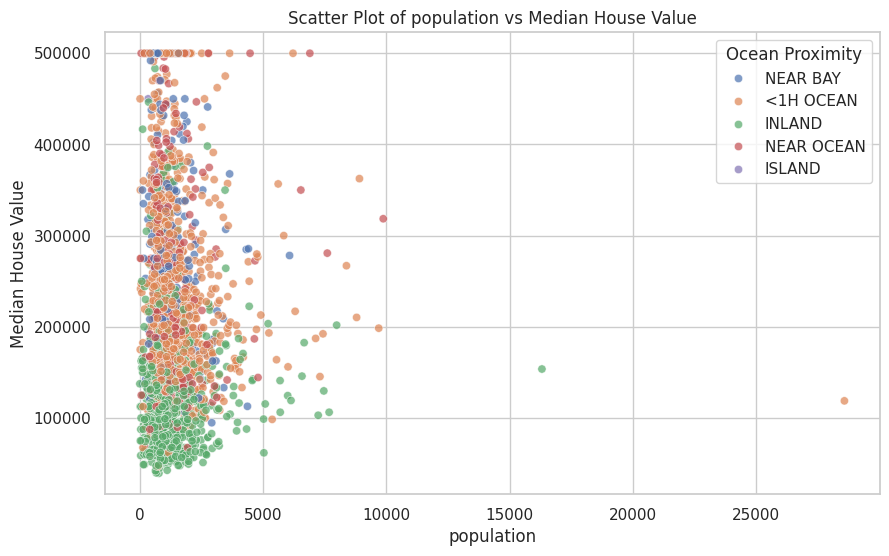

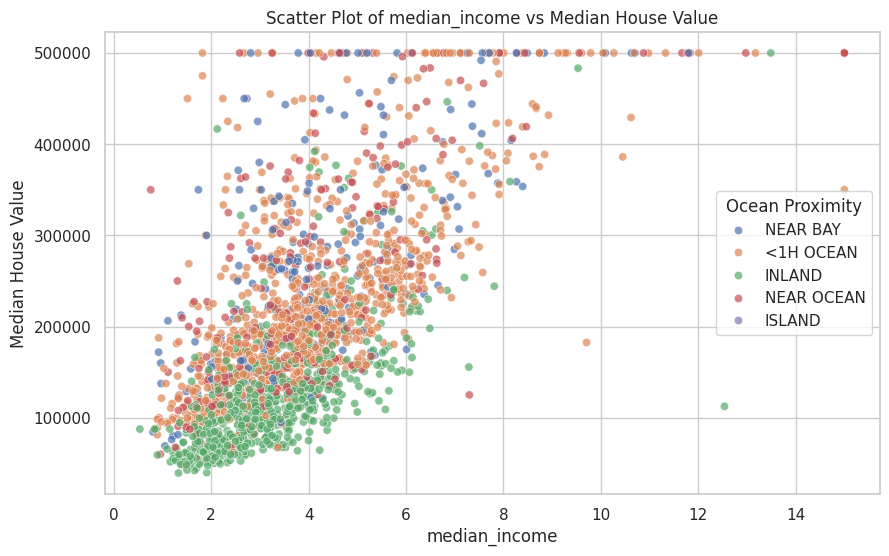

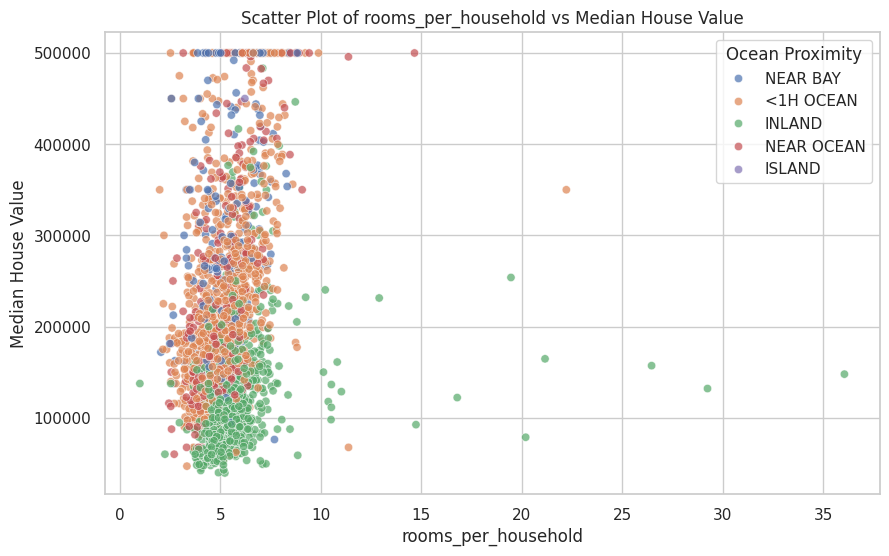

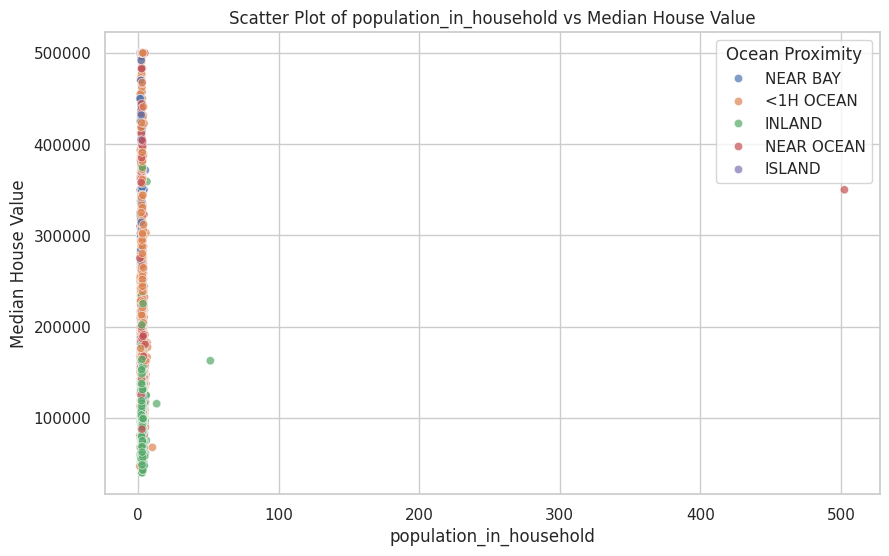

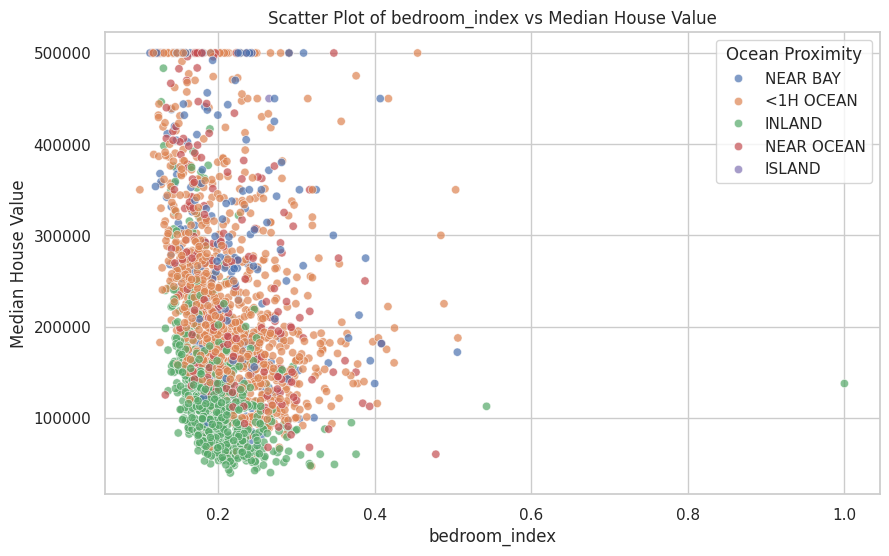

In [63]:
cols = [
    'households',
    'longitude',
    'latitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'median_income',
    #'median_house_value',
    #'ocean_proximity',
    'rooms_per_household',
    'population_in_household',
    'bedroom_index'
]


# sns.pairplot(_df, x_vars=cols, y_vars='median_house_value', hue='ocean_proximity')
for col in cols:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=_df, x=col, y='median_house_value', hue='ocean_proximity', alpha=0.7)
    plt.title(f'Scatter Plot of {col} vs Median House Value')
    plt.xlabel(col)
    plt.ylabel('Median House Value')
    plt.legend(title='Ocean Proximity')
    plt.show()

- There is no linear relationships between the features and the target variable, which is why the Linear Regression is likely to show poor metrics.

## 6. Data Preprocessing and Modelling (Linear Regression)

6.1 Split into Train and Test Sets

In [64]:
# Split the data into train and test sets

train, test = df.randomSplit([.8, .2], seed=RANDOM_SEED)

In [65]:
train.count()

16556

In [66]:
test.count()

4078

6.2 Define numeric and categorical feature columns

In [67]:
# Numeric and categorical feature columns
num_cols = [
    'households',
    'longitude',
    'latitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'median_income',
    #'median_house_value',
    #'ocean_proximity',
    'rooms_per_household',
    'population_in_household',
    'bedroom_index'
]

cat_col = 'ocean_proximity'

target_col = 'median_house_value'

6.3 Preprocessing Stage: Initialize feature transformers

In [68]:
# Categorical feature transformers
indexer = StringIndexer(
    inputCol=cat_col,
    outputCol=cat_col + '_indexed',
    stringOrderType='frequencyDesc'
)

ohe = OneHotEncoder(
    inputCol=cat_col + '_indexed',
    outputCol=cat_col + '_encoded'
)

# Numeric feature transformers
vecAssembler = VectorAssembler(
    inputCols=num_cols,
    outputCol='numeric_features'
)

scaler = StandardScaler(
    inputCol='numeric_features',
    outputCol='numeric_features_scaled'
)

# Final feature vector assembler for the full model
vecAssembler_full = VectorAssembler(
    inputCols=[
        cat_col+'_encoded',
        'numeric_features_scaled'
    ],
    outputCol='features'
)

# Final feature vector assembler for the numeric-only model
vecAssembler_numeric = VectorAssembler(
    inputCols=['numeric_features_scaled'],
    outputCol='features'
)

6.4 Preprocessing Stage: Pipelines for preprocessing

In [69]:
# Categorical features preprocessing pipeline
cat_preprocessor = Pipeline(stages=[indexer, ohe])

# Numeric features preprocessing
num_preprocessor = Pipeline(stages=[vecAssembler, scaler])

6.5 Models

In [70]:
# Linear Regession models initialisation

lr_full = LinearRegression(
    featuresCol='features',
    labelCol=target_col
)

lr_numeric = LinearRegression(
    featuresCol='features',
    labelCol=target_col
)

6.6 Cross validation set up

In [71]:
# Set up the parameter grid for CrossValidator
paramGrid_full = ParamGridBuilder() \
    .addGrid(lr_full.regParam, [0.1, 0.01]) \
    .addGrid(lr_full.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

paramGrid_numeric = ParamGridBuilder() \
    .addGrid(lr_numeric.regParam, [0.1, 0.01]) \
    .addGrid(lr_numeric.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

6.7 Full model

In [72]:
# Initialize CrossValidator for the full model
crossval_full = CrossValidator(
    estimator=Pipeline(stages=[cat_preprocessor, num_preprocessor, vecAssembler_full, lr_full]),
    estimatorParamMaps=paramGrid_full,
    evaluator=RegressionEvaluator(labelCol=target_col, predictionCol="prediction"),
    numFolds=5
)

# Fit the full model using CrossValidator
cvModel_full = crossval_full.fit(train)

# Predictions for the full model
predictions_full = cvModel_full.transform(test)

6.8 Numeric-only model

In [73]:
# Initialize CrossValidator for the numeric-only model
crossval_numeric = CrossValidator(
    estimator=Pipeline(stages=[num_preprocessor, vecAssembler_numeric, lr_numeric]),
    estimatorParamMaps=paramGrid_numeric,
    evaluator=RegressionEvaluator(labelCol=target_col, predictionCol="prediction"),
    numFolds=5
)

# Fit the numeric-only model using CrossValidator
cvModel_numeric = crossval_numeric.fit(train)

# Predictions for the numeric-only model
predictions_numeric = cvModel_numeric.transform(test)

6.9 Metrics

In [74]:
# Evaluation metrics for the full model
evaluator = RegressionEvaluator(labelCol=target_col, predictionCol="prediction")

# Full model metrics
rmse_full = evaluator.evaluate(predictions_full, {evaluator.metricName: "rmse"})
mae_full = evaluator.evaluate(predictions_full, {evaluator.metricName: "mae"})
r2_full = evaluator.evaluate(predictions_full, {evaluator.metricName: "r2"})

print(f"Full Model - RMSE: {rmse_full}, MAE: {mae_full}, R2: {r2_full}")

# Evaluation metrics for the numeric-only model
rmse_numeric = evaluator.evaluate(predictions_numeric, {evaluator.metricName: "rmse"})
mae_numeric = evaluator.evaluate(predictions_numeric, {evaluator.metricName: "mae"})
r2_numeric = evaluator.evaluate(predictions_numeric, {evaluator.metricName: "r2"})

print(f"Numeric-Only Model - RMSE: {rmse_numeric}, MAE: {mae_numeric}, R2: {r2_numeric}")

Full Model - RMSE: 68870.29064841669, MAE: 49531.14467616328, R2: 0.6454365605565184
Numeric-Only Model - RMSE: 69651.62628353438, MAE: 50260.3401838721, R2: 0.6373458578195024


In [75]:
df.printSchema()

root
 |-- households: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)
 |-- rooms_per_household: double (nullable = true)
 |-- population_in_household: double (nullable = true)
 |-- bedroom_index: double (nullable = true)



**Full Model**

- RMSE of about 68,892 suggests that, on average, the model's predictions are off by this amount.

- This metric also measures the average error, but it takes the absolute value of errors, which means it treats all errors equally regardless of direction (overestimates vs. underestimates). An MAE of about 49,570 suggests that the model's predictions are off by this amount on average.

- R² of 0.6452 means that approximately 64.52% of the variance in the target variable can be explained by the model.

**Numeric-Only Model**
- RMSE 69650.10 is slightly higher than that of the full model, indicating that it is generally less accurate.

- The MAE is also higher for the numeric-only model, indicating that it, too, has larger average prediction errors compared to the full model.

- R²: 0.6374 a slightly lower value than the full model, suggesting it explains a smaller portion of the variance in the target variable.

**Summary of Comparison**
- The full model (with both categorical and numeric features) performs better in terms of RMSE and MAE, indicating it has a more accurate prediction capability.
- The R² value is higher for the full model, suggesting that including categorical features helps capture more variability in the target variable.

## 7. Random Forest Regressor

In [76]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator

In [77]:
train, test = df.randomSplit([.8, .2], seed=RANDOM_SEED)

# Numeric and categorical feature columns
num_cols = [
    'households',
    'longitude',
    'latitude',
    'housing_median_age',
    'total_rooms',
    'total_bedrooms',
    'population',
    'median_income',
    #'median_house_value',
    #'ocean_proximity',
    'rooms_per_household',
    'population_in_household',
    'bedroom_index'
]

cat_col = 'ocean_proximity'

target_col = 'median_house_value'

# Categorical feature transformers
indexer = StringIndexer(
    inputCol=cat_col,
    outputCol=cat_col + '_indexed',
    stringOrderType='frequencyDesc'
)

# Numeric feature transformers
vecAssembler = VectorAssembler(
    inputCols=num_cols + [cat_col + '_indexed'],
    outputCol='features'
)

# Automatically identify categorical features, and index them
featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4)


# Train a RandomForest model
rf = RandomForestRegressor(featuresCol="indexedFeatures", labelCol=target_col)

pipeline = Pipeline(stages=[indexer, vecAssembler, featureIndexer, rf])

model = pipeline.fit(train)

predictions = model.transform(test)

In [78]:
predictions.show(5)

+----------+---------+--------+------------------+-----------+--------------+----------+-------------+------------------+---------------+-------------------+-----------------------+-------------------+-----------------------+--------------------+--------------------+------------------+
|households|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|median_income|median_house_value|ocean_proximity|rooms_per_household|population_in_household|      bedroom_index|ocean_proximity_indexed|            features|     indexedFeatures|        prediction|
+----------+---------+--------+------------------+-----------+--------------+----------+-------------+------------------+---------------+-------------------+-----------------------+-------------------+-----------------------+--------------------+--------------------+------------------+
|       2.0|  -117.79|   35.21|               4.0|        2.0|           2.0|       6.0|        2.375|          137500.0|         INLAND|  

In [79]:
# Example rows to display
predictions.select("prediction", target_col, "features").show(5)


+------------------+------------------+--------------------+
|        prediction|median_house_value|            features|
+------------------+------------------+--------------------+
|102036.19743238807|          137500.0|[2.0,-117.79,35.2...|
|117156.26240509408|           42500.0|[3.0,-116.76,34.1...|
|268683.00950301683|          375000.0|[4.0,-122.06,37.3...|
| 239080.7122320232|          137500.0|[5.0,-122.0,37.0,...|
|237758.37356933602|          137500.0|[6.0,-121.98,38.3...|
+------------------+------------------+--------------------+
only showing top 5 rows



In [80]:
# Metrics
evaluator = RegressionEvaluator(labelCol=target_col, predictionCol="prediction")

rmse_full = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
mae_full = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})
r2_full = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print(f"Random Forest - RMSE: {rmse_full}, MAE: {mae_full}, R2: {r2_full}")

Random Forest - RMSE: 65899.82982970885, MAE: 47907.56460573515, R2: 0.6753624842945349


- The Random Forest model shows better performance than both the full model and the numeric-only model, as indicated by its lower RMSE and MAE. This means it is more accurate in its predictions.

- With an R² of 0.6685, the Random Forest model explains a bigger portion of the variance in the target variable.

In [81]:
spark.stop()